# Get the tutorial materials

+ Download zip:
    In a browser go to https://github.com/aarontuor/tf_tutorials. Click clone or download button.
+ Or clone the repo:
    ```bash
    $> git clone https://github.com/aarontuor/tf_tutorials.git
    ```



# Tensorflow virtualenv install

```bash
$> virtualenv --system-site-packages ~/tf_tutorials
$> source ~/tf_tutorials/bin/activate
$> export TF_BINARY_URL=https://storage.googleapis.com/tensorflow/linux/cpu/tensorflow-0.11.0rc0-cp27-none-linux_x86_64.whl
$> pip install --upgrade $TF_BINARY_URL
```

# Jupyter Notebook Install with Codefolding extension

```bash
$> pip install jupyter
$> pip install https://github.com/ipython-contrib/jupyter_contrib_nbextensions/tarball/master
$> jupyter contrib nbextension install --user 
$> jupyter nbextension enable codefolding/main
```


# Matplotlib pip install
```bash
$> pip install matplotlib
```

# ANTk pip install

```bash
$> pip install antk
```

# Tensorflow Introduction: Neural Network

A neural network is just a parametric function. If you can find the right parameters, and have a large enough hidden layer size, a two layer neural network can 
approximate any function!

Let $x \in \mathbb{R}^{1 \times n}, W \in \mathbb{R}^{n \times m},$ and $ U \in \mathbb{R}^{m \times p}$. A two layer neural network is the parametric function $\mathcal{q}: \mathbb{R}^{1 \times n} \rightarrow \mathbb{R}^{1 \times p}$ where 
$\mathcal{q} = g( U f(x W + b) + c)$, $U, W, b, c$ are the parameters to be learned, and the functions $g,h$ are model choices.

![nnet graph](nnet_graph.png)

Training a neural network involves a forward pass, which evaluates the function $q$ for a given set of parameters, and a backward pass which adjusts the parameters using gradient descent by way of the backpropagation algorithm, depending on how well $q$ approximates the training example targets. Tensorflow takes care of the math for the backward pass so we only need to worry about coding the forward pass for training.

There are several choices for $f$. Below are a few:

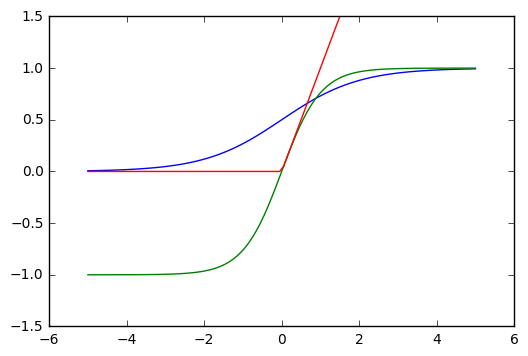

In [17]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np 
from antk.core.loader import DataSet

x = np.linspace(-5, 5, 100) # 100 linearly spaced numbers between -10, 10

# elementwise sigmoid
f1 = 1/(1+np.exp(-x))

# hyperbolic tangent: tanh
f2 = (np.exp(2*x) -1)/(np.exp(2*x) + 1)

# rectified linear units
f3 = np.maximum(np.zeros(x.shape), x)

plt.plot(x,f1, x, f2, x, f3)
plt.gca().set_ylim(bottom=-1.5, top=1.5)
plt.show()

In [18]:
# Retrieve data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Below is the computational graph of the function we want to make. Notice that $X$ is not a vector but a batch of vectors stacked together in a matrix, so we can send many vectors at a time through the neural net for training. 

![nnet graph](batch_nnet.png)


In [19]:
# Make a graph and set as default
g = tf.Graph()
g.as_default() # Also better "with tf.Graph().as_default() as g:"

# First make placeholders for inputs and targets
x = tf.placeholder(tf.float32, shape=[None, 784]) # The none dimension leaves us free to choose a batch_size at runtime
y = tf.placeholder(tf.float32, shape=[None, 10]) # Ten classes of digits

# Now make trainable variables
W = tf.Variable(0.01*tf.truncated_normal([784, 50], mean=0.0, stddev=1.0, dtype=tf.float32, seed=None, name='W'))
U = tf.Variable(0.01*tf.truncated_normal([50, 10], mean=0.0, stddev=1.0, dtype=tf.float32, seed=None, name='U'))

b = tf.Variable(tf.zeros([50])) # These don't need to be batchsize X 50 because of TF broadcasting
c = tf.Variable(tf.zeros([10])) # Actually we really don't want the extra dimension because we want the bias to repeat

In [20]:
# Now compute q
h = tf.nn.relu(tf.matmul(x, W) + b) # The hidden layer
q = tf.nn.softmax(tf.matmul(h,U) + c)

In [21]:
# Loss function
cross_entropy = -tf.reduce_sum(y*tf.log(q))

# Train step
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

# Evaluate
correct_prediction = tf.equal(tf.argmax(q,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

init = tf.initialize_all_variables()

sess = tf.Session()
sess.run(init)

In [22]:
import sys 
import time

for i in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y: batch_ys})
    sys.stdout.write('%s' % sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels}))
    time.sleep(.15)
    sys.stdout.write('\r')
sess.close() # release resources allocated to session also "with tf.Session() as sess:"

0.8715

KeyboardInterrupt: 

## A reusable nnet
This code is perfectly usable but we've written a perfectly good neural network that only works with the vectorized mnist data (or some other 784 dimensional data set)! Let's make our neural network reusable. 

In [ ]:
# pass 1 at nnet classifier
def nnet_classifier1(x, hidden_size, output_size, activation):
    """
    First pass at a classifier
    
    :param x: Input to the network
    :param hidden_size: Size of second dimension of W the first weight matrix
    :param output_size: Size of second dimension of U the second weight matrix
    """
    fan_in = x.get_shape().as_list()[1]
    scale = 1.0/np.sqrt(fan_in)
    W = tf.Variable(scale*tf.truncated_normal([fan_in, hidden_size], 
                                             mean=0.0, stddev=1.0, 
                                             dtype=tf.float32, seed=None, name='W'))
    
    scale = 1.0/np.sqrt(hidden_size)
    U = tf.Variable(scale*tf.truncated_normal([hidden_size, output_size], 
                                              mean=0.0, stddev=1.0, dtype=tf.float32, 
                                              seed=None, name='U'))

    b = tf.Variable(tf.zeros([hidden_size]))
    c = tf.Variable(tf.zeros([output_size]))
    
    h = activation(tf.matmul(x, W) + b) # The hidden layer
    return tf.nn.softmax(tf.matmul(h,U) + c)


## A better reusable nnet

Our last attempt was better but we have restricted our neural net op to a neural network with one hidden layer. 
Let's make this network capable of arbitrarily depth and hidden layer sizes. 

In [10]:
# pass 2 at nnet classifier
def nnet_classifier2(x, layers=[50,10], act=tf.nn.relu, name='nnet'):
    """
    Second pass at a classifier, eliminate repeated code. Bonus: An arbitrarilly deep neural network.
    
    :param x: Input to the network
    :param layers: Sizes of network layers
    :param act: Activation function to produce hidden layers of neural network.
    :param name: An identifier for retrieving tensors made by dnn
    """
    
    for ind, hidden_size in enumerate(layers):
        with tf.variable_scope('layer_%s' % ind):
            fan_in = x.get_shape().as_list()[1]
            scale = 1.0/np.sqrt(fan_in)
            W = tf.Variable(scale*tf.truncated_normal([fan_in, hidden_size], 
                                                     mean=0.0, stddev=1.0, 
                                                     dtype=tf.float32, seed=None, name='W'))
            tf.add_to_collection(name + '_weights', W)
            b = tf.Variable(tf.zeros([hidden_size])) 
            tf.add_to_collection(name + '_bias', b)
            x = tf.matmul(x,W) + b
            if ind != len(layers) - 1:
                x = act(x, name='h' + str(ind)) # The hidden layer
            tf.add_to_collection(name + '_activation', x)
    return tf.nn.softmax(x)

## Eliminate boilerplate training code by making a reusable model class

In [11]:
class SimpleModel():
    """
    A class for gradient descent training arbitrary models.
    
    :param loss: loss_tensor defined in graph
    :param eval_tensor: For evaluating on dev set
    :param ph_dict: A dictionary of tensorflow placeholders
    :param learnrate: step_size for gradient descent
    :param debug: Whether to print debugging info 
    """
    
    def __init__(self, loss, eval_tensor, ph_dict, learnrate=0.01, debug=False):
        self.loss = loss
        self.ph_dict = ph_dict
        self.eval_tensor = eval_tensor
        self.debug=debug
        self.train_step = tf.train.GradientDescentOptimizer(learnrate).minimize(loss)
        self.init = tf.initialize_all_variables()
        self.epoch = 0.0
        self.sess = tf.Session()
        self.sess.run(self.init)
        
    def train(self, train_data, dev_data, mb=1000, num_epochs=1):
        """
        :param train_data: A DataSet object of train data.
        :param dev_data: A DataSet object of dev data.
        :param mb: The mini-batch size.
        :param num_epochs: How many epochs to train for.
        """
        while self.epoch < num_epochs:
            self.epoch += float(mb)/float(train.num_examples)
            new_batch = train.next_batch(mb)
            self.sess.run(self.train_step, feed_dict=self.get_feed_dict(new_batch, self.ph_dict))
            sys.stdout.write('epoch %.2f\tdev eval: %.4f' % (self.epoch, self.evaluate(dev_data)))
            time.sleep(.2)
            sys.stdout.write('\r')
        
    def evaluate(self, data):
        """
        Evaluation function
        
        :param data: The data to evaluate on.
        :return: The return value of the evaluation function in numpy form
        """
        return self.sess.run(self.eval_tensor, feed_dict=self.get_feed_dict(data, self.ph_dict))
                                 
    def get_feed_dict(self, batch, ph_dict):

        """
        :param batch: A dataset object.
        :param ph_dict: A dictionary where the keys match keys in batch, and the values are placeholder tensors
        :return: A feed dictionary with keys of placeholder tensors and values of numpy matrices
        """
        
        datadict = batch.features.copy()
        datadict.update(batch.labels)
                                 
        if self.debug:
            for desc in ph_dict:
                print('%s\n\tph: %s\t%s\tdt: %s\t%s' % (desc,
                                                        ph_dict[desc].get_shape().as_list(), ph_dict[desc].dtype, 
                                                        datadict[desc].shape, datadict[desc].dtype))
        return {ph_dict[key]:datadict[key] for key in ph_dict}

## Testing SimpleModel class, and nnet_classifier operation

In [15]:
import sys
import time
import tensorflow as tf
from antk.core.loader import DataSet

# Data prep ================================================================
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
train = DataSet({'images': mnist.train.images}, labels={'digits': mnist.train.labels}, mix=False)
dev = DataSet({'images': mnist.test.images}, labels={'digits': mnist.test.labels}, mix=False)

# Make graph ============================================================
ph_dict = {'images': tf.placeholder(tf.float32, shape=[None, 784]),
           'digits': tf.placeholder(tf.float32, shape=[None, 10])}

prediction = nnet_classifier2(ph_dict['images'], 
                             layers = [50, 10], 
                             act = tf.nn.relu, 
                             name='nnet')

# Loss function
cross_entropy = -tf.reduce_sum(ph_dict['digits']*tf.log(prediction))

# Evaluate
correct_prediction = tf.equal(tf.argmax(prediction,1), tf.argmax(ph_dict['digits'],1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Make model
model = SimpleModel(cross_entropy, accuracy, ph_dict, learnrate=0.01)

# Train ================================================================
model.train(train, dev, mb=100, num_epochs=10)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
